# Comparison zfp vs sz and model

In [1]:
import numpy as np
import time
import xarray as xr
import subprocess
import os
import zfpy
import matplotlib.pyplot as plt
from lossycomp.compress import compress
from lossycomp.decompress import decompress
from lossycomp.plots import single_plot
from lossycomp.encodings import encode_lat, encode_lon

In [2]:
data_or = xr.open_mfdataset('/lsdf/kit/scc/projects/abcde/1980/*/ERA5.pl.temperature.nc', combine='by_coords')
data_or = data_or.sel(time=slice('1980-5-1T00:00:00','1980-5-31T23:00:00'),level = slice(978,1000), longitude=slice(20,70), latitude=slice(60,10))
data_or = data_or.transpose('time', 'latitude', 'longitude', 'level')
data_or = data_or['t']
data_or = data_or.values

(744, 201, 201, 1)
float32


In [3]:
abs_error = 1

In [4]:
filename = 'zexact.dat'
data_or[:,:,:,0].tofile(filename)

subprocess.run(['../../SZ/build/bin/sz', '-z', '-f','-M', 'ABS', '-A', '0.1','-i',  filename, '-3', '744','201' ,'201'], 
               stdout=subprocess.DEVNULL, stderr=subprocess.STDOUT)


subprocess.run(['../../SZ/build/bin/sz', '-x', '-f', '-s', filename + '.sz', '-3',  '744', '201' ,'201'],
               stdout=subprocess.DEVNULL, stderr=subprocess.STDOUT)

z_sz = np.fromfile(filename + '.sz.out', dtype= np.float32)
z_sz = z_sz.reshape(data_or[:,:,:,0].shape)



print('SZ',  data_or[:,:,:,0].nbytes/os.path.getsize(filename + '.sz'))


# Cleanup
os.remove(filename)
os.remove(filename + '.sz')
os.remove(filename + '.sz.out')

SZ 6.522288316649155


In [5]:
np.max(z_sz)

257202750.0

## Original Data

(1, 744, 201, 201, 1)


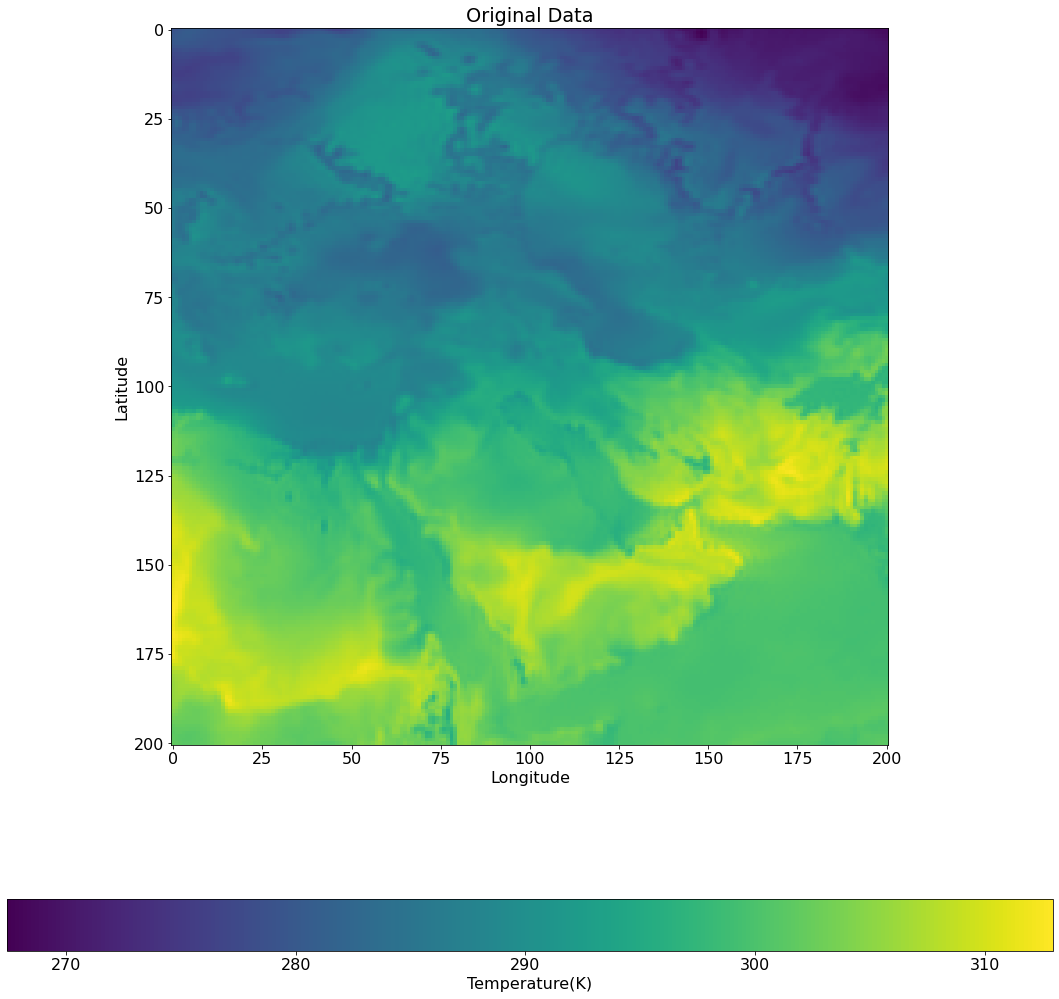

In [49]:
data_r = np.expand_dims(data_or[:,:,:,0], axis=0)
#data_r = np.expand_dims(data_or, axis=0)
data_r = np.expand_dims(data_r, axis=4)
print(data_r.shape)
plt.rcParams.update({'font.size': 16})
single_plot(data_r, 0, "Original Data", "Temperature(K)", data_r[0,0].min(), data_r[0,0].max())

## Model

In [50]:
compressed_data = compress(data_or, abs_error, extra_channels = False, verbose = True, method='mask', mode = 'None', convs = 4, hyp = 15)
decompressed_data = decompress(compressed_data, extra_channels = False, verbose = False, method='mask', mode = 'None', convs = 4, hyp = 15)

{'num_convs': 4, 'num_filters': 20, 'kernel_size': 4, 'lr': 2.2072068732995733e-05, 'res_blocks': 0, 'l2': 3.8386543759492194e-05, 'extra': False, 'gaussian': False}
Load model...
Model: "Autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 16, 48, 48, 1)]   0         
_________________________________________________________________
Encoder (Functional)         (None, 1, 3, 3, 20)       78160     
_________________________________________________________________
Decoder (Functional)         (None, 16, 48, 48, 1)     103761    
Total params: 181,921
Trainable params: 181,921
Non-trainable params: 0
_________________________________________________________________
None
Standardizing data...
Chunking data...
Compressing data...
compressed.
Start decompressing
decompressed
(1175, 16, 48, 48, 1)
Merging data...
Quantizing data...
Encoding data...
Compression fact

In [51]:
def psnr(y,x):
    vrange = np.max(y) - np.min(y)
    psnr = 20 * np.log10(vrange - (10 * np.log10(np.mean((y-x)*(y-x)))))
    return psnr


psnr1 = psnr(data_or[0,:,:,0], decompressed_data[0,:,:,0])
print('PSNR', psnr1)

#np.testing.assert_allclose(data_or, decompressed_data, atol=abs_error, rtol=1e-4)

PSNR 34.109816142604764


(1, 744, 201, 201, 1)


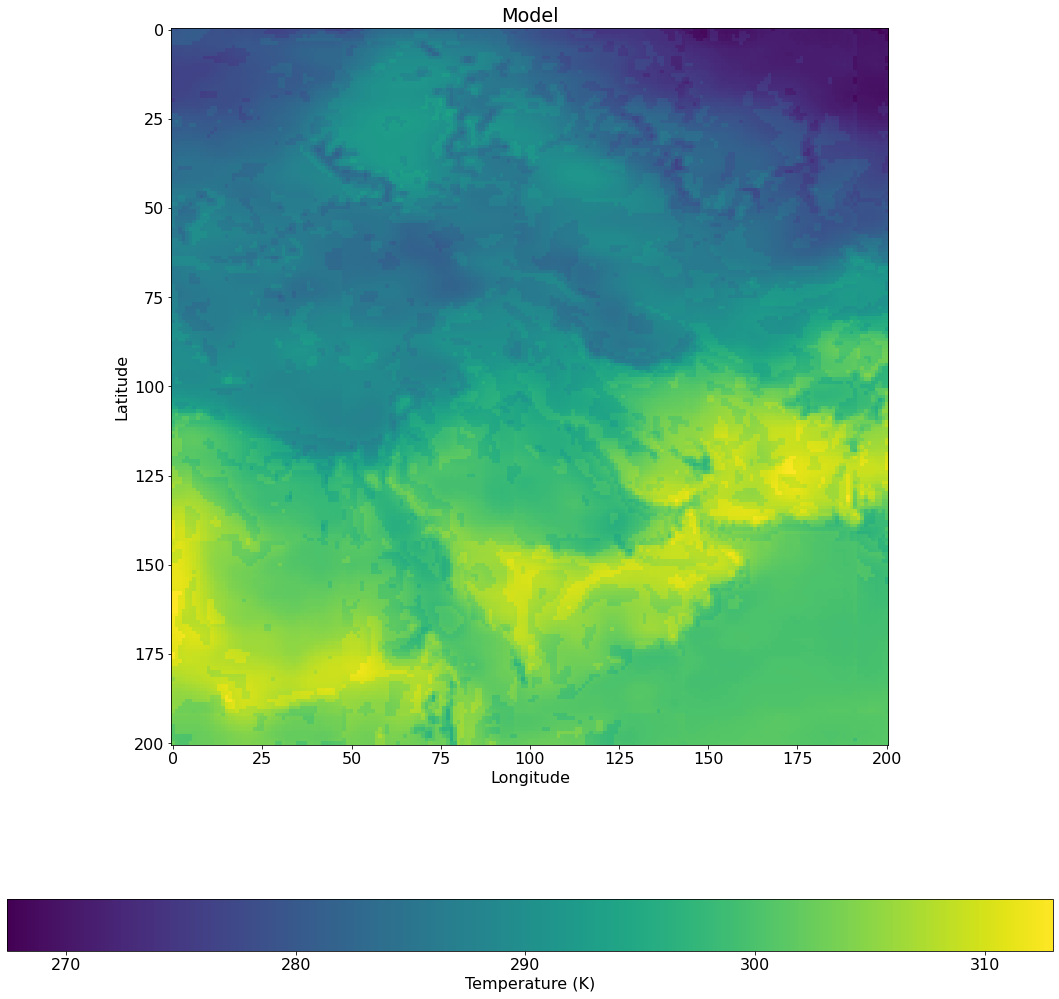

In [52]:
decom = np.expand_dims(decompressed_data, axis=0)
print(decom.shape)
single_plot(decom, 0, "Model", "Temperature (K)", data_r[0,0].min(), data_r[0,0].max())

## ZFP

In [53]:
compressed_data = zfpy.compress_numpy(data_or[:,:,:,0],  tolerance=abs_error)
decompressed_array = zfpy.decompress_numpy(compressed_data)
print('CF: ', data_or[:,:,:,0].nbytes / len(compressed_data) )

CF:  9.719101835672815


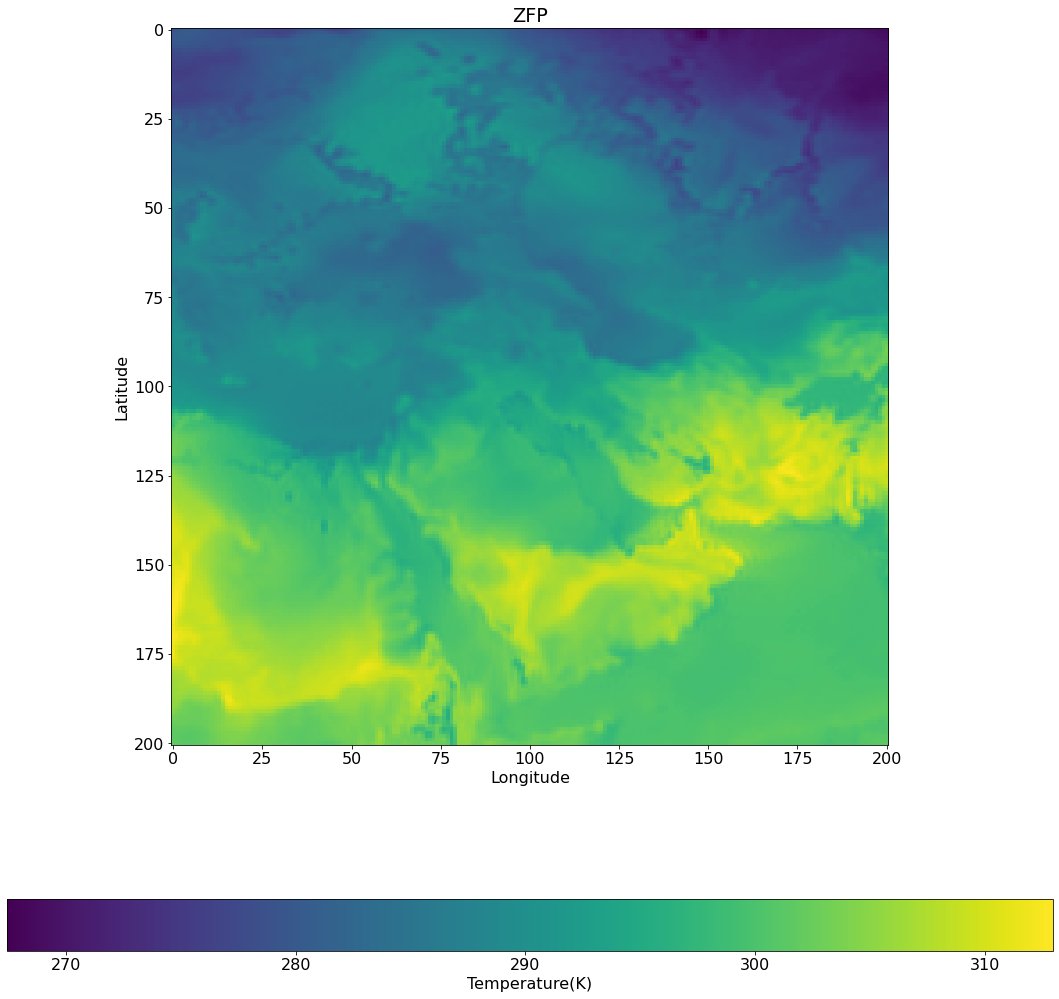

In [54]:
data_zfp = np.expand_dims(decompressed_array, axis=0)
data_zfp = np.expand_dims(data_zfp, axis=4)
single_plot(data_zfp, 0, "ZFP", "Temperature(K)", data_r[0,0].min(), data_r[0,0].max())

In [55]:
psnr1 = psnr(data_or[0,:,:,0], decompressed_array[0,:,:])
print('PSNR', psnr1)

#np.testing.assert_allclose(data_or[:,:,:,0], decompressed_array, atol=abs_error)

PSNR 37.347788090895335


## SZ

In [79]:
filename = 'zexact.dat'
data_or[:,:,:,0].tofile(filename)

subprocess.run(['../../SZ/build/bin/sz', '-z', '-f','-M', 'ABS', '-A', str(abs_error),'-i',  filename, '-3', '744','201' ,'201'], 
               stdout=subprocess.DEVNULL, stderr=subprocess.STDOUT)


subprocess.run(['../../SZ/build/bin/sz', '-x', '-f', '-s', filename + '.sz', '-3',  '744', '201' ,'201'],
               stdout=subprocess.DEVNULL, stderr=subprocess.STDOUT)

z_sz = np.fromfile(filename + '.sz.out', dtype= np.float32)
z_sz = z_sz.reshape(data_or[:,:,:,0].shape)



print('SZ',  data_or[:,:,:,0].nbytes/os.path.getsize(filename + '.sz'))


# Cleanup
os.remove(filename)
os.remove(filename + '.sz')
os.remove(filename + '.sz.out')



(744, 201, 201)
SZ 15.132030082985333


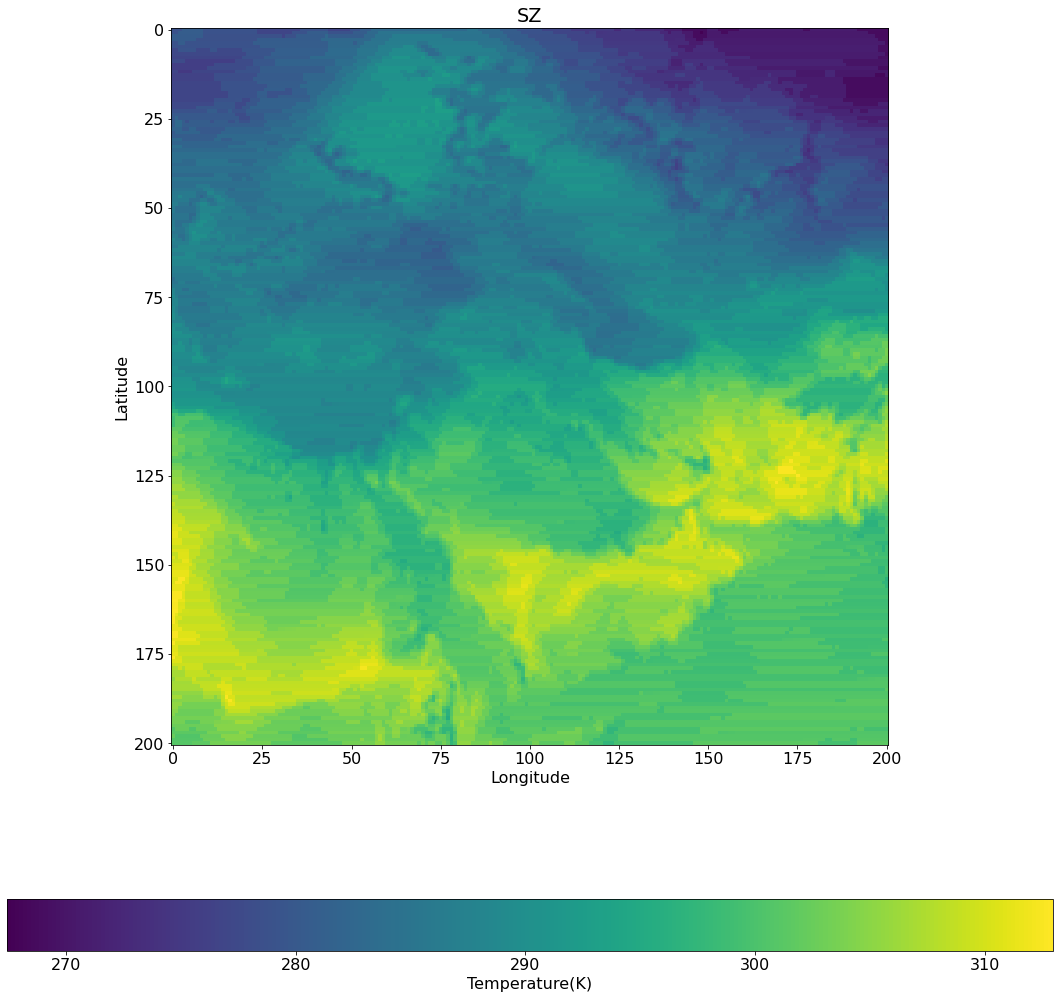

In [76]:
data_sz = np.expand_dims(z_sz, axis=0)
data_sz = np.expand_dims(data_sz, axis=4)
single_plot(data_sz, 0, "SZ", "Temperature(K)", data_r[0,0].min(), data_r[0,0].max())

In [ ]:
psnr1 = psnr(data_or[0,:,:,0], z_sz[0,:,:])
print('PSNR', psnr1)

np.testing.assert_allclose(data_or[:,:,:,0], z_sz, atol=abs_error, rtol=1e-2)